# Libraries

In [34]:
# Main
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Sklearn
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder

# Keras
import tensorflow as tf
from tensorflow.keras import regularizers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, concatenate
from tensorflow.keras.optimizers import Adam, Adamax, Nadam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Other
import os

# Setup

In [35]:
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None

In [36]:
plt.style.use('fivethirtyeight')

In [37]:
path = "../CSV Files"

train = pd.read_csv(path+"/train.csv", index_col="id")
test = pd.read_csv(path+"/test.csv",  index_col="id")

# Functions

In [38]:
def wrangle(X):
    # make a copy
    X = X.copy()
    
    # encode "t" and "f" as 1's and 0's
    X['host_has_profile_pic'][X['host_has_profile_pic']=='t'] = 1
    X['host_has_profile_pic'][X['host_has_profile_pic']=='f'] = 0
    
    X['host_identity_verified'][X['host_identity_verified']=='t'] = 1
    X['host_identity_verified'][X['host_identity_verified']=='f'] = 0
    
    X['host_has_profile_pic'] = X['host_has_profile_pic'].astype(float)
    X['host_identity_verified'] = X['host_identity_verified'].astype(float)
    
    X['instant_bookable'][X['instant_bookable']=='t'] = 1
    X['instant_bookable'][X['instant_bookable']=='f'] = 0
    
    # Group some of the many property types together
    X['property_type'][X['property_type'].isin(['Boat','Tent','Castle','Yurt', 'Hut', 'Treehouse',
                                                'Chalet','Earth House','Tipi','Cave',
                                                'Train','Parking Space','Island','Casa particular',
                                                'Lighthouse', 'Vacation home', 'Serviced apartment'])] = 'Other'

    # columns with unusable variance
    unusable_variance = ['zipcode']

    # columns with high percentage of missing values
    high_nans = ['first_review','host_response_rate','last_review',
                 'review_scores_rating','thumbnail_url']

    # categorical variables with high cardinality
    # 'neighborhood' has 620 and 'thumbnail_url' has many thousands
    high_card = ['neighbourhood','thumbnail_url','name','amenities',
                 'description', 'host_since']

    # Get the price and drop the log of price
    X['price'] = np.exp(X['log_price'])
    X = X.drop(['log_price'] + unusable_variance + high_nans + high_card, axis=1)

    return X

In [39]:
def prepare_inputs(X_train, X_test):
    X_train_enc, X_test_enc = list(), list()
    # label encode each column
    for i in range(X_train.shape[1]):
        le = LabelEncoder()
        # encode
        train_enc = le.fit_transform(X_train.iloc[:, i].values)
        test_enc = le.fit_transform(X_test.iloc[:, i].values)
        # store
        X_train_enc.append(train_enc)
        X_test_enc.append(test_enc)
    return X_train_enc, X_test_enc

In [40]:
def scale_inputs(X_train, X_test):
    ss = StandardScaler()
    ss.fit_transform(X_train, X_test)
    return X_train, X_test

In [41]:
def model_creation_emb():
    lr = .0065
    opt = Adam(lr)
    prob = .75
    l2 = 0.5
    
    il_nodes = 64*8
    hl_nodes_1 = 64*8
    hl_nodes_2 = 64*8
#     hl_nodes_3 = 64*8
#     hl_nodes_4 = 64*8
    ol_nodes = 1
    
    dense = Dense(il_nodes,
                  activation='relu',
                  kernel_regularizer=regularizers.l2(l2))(emb)
    
    dense = Dense(hl_nodes_1, activation='relu',
                  kernel_regularizer=regularizers.l2(l2))(dense)
    
    dropout = Dropout(prob)(dense)
    
    dense = Dense(hl_nodes_2, activation='relu',
                  kernel_regularizer=regularizers.l2(l2))(dense)
    
    dropout = Dropout(prob)(dense)
    
    output = Dense(ol_nodes,
                   activation='linear')(dense)
    
    model = Model(inputs=in_layers,
                  outputs=output)
    
    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    return model

# EDA

In [42]:
print(train.shape)
train.head()

(74111, 28)


,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 6901257 to 3534845
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               74111 non-null  float64
 1   property_type           74111 non-null  object 
 2   room_type               74111 non-null  object 
 3   amenities               74111 non-null  object 
 4   accommodates            74111 non-null  int64  
 5   bathrooms               73911 non-null  float64
 6   bed_type                74111 non-null  object 
 7   cancellation_policy     74111 non-null  object 
 8   cleaning_fee            74111 non-null  bool   
 9   city                    74111 non-null  object 
 10  description             74111 non-null  object 
 11  first_review            58247 non-null  object 
 12  host_has_profile_pic    73923 non-null  object 
 13  host_identity_verified  73923 non-null  object 
 14  host_response_rate      55812 

In [44]:
train = wrangle(train)

In [45]:
train.head()

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,bedrooms,beds,price
id,,,,,,,,,,,,,,,,,
6901257,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,1.0,1.0,0,40.696524,-73.991617,2,1.0,1.0,150.0
6304928,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,1.0,0.0,1,40.766115,-73.989040,6,3.0,3.0,169.0
7919400,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,1.0,1.0,1,40.808110,-73.943756,10,1.0,3.0,145.0
13418779,House,Entire home/apt,4,1.0,Real Bed,flexible,True,SF,1.0,1.0,0,37.772004,-122.431619,0,2.0,2.0,750.0
3808709,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,1.0,1.0,1,38.925627,-77.034596,4,0.0,1.0,115.0


In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 6901257 to 3534845
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_type           74111 non-null  object 
 1   room_type               74111 non-null  object 
 2   accommodates            74111 non-null  int64  
 3   bathrooms               73911 non-null  float64
 4   bed_type                74111 non-null  object 
 5   cancellation_policy     74111 non-null  object 
 6   cleaning_fee            74111 non-null  bool   
 7   city                    74111 non-null  object 
 8   host_has_profile_pic    73923 non-null  float64
 9   host_identity_verified  73923 non-null  float64
 10  instant_bookable        74111 non-null  object 
 11  latitude                74111 non-null  float64
 12  longitude               74111 non-null  float64
 13  number_of_reviews       74111 non-null  int64  
 14  bedrooms                74020 

# Split

In [47]:
target = 'price'
X = train.drop(target, axis=1)
y = train[target]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.20,
                                                    random_state=0)

In [49]:
print(X_train.shape)
print(X_test.shape)

(59288, 16)
(14823, 16)


# Baseline

In [50]:
baseline = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
print('Baseline MAE:', round(baseline,2))

Baseline MAE: 97.59


# Pre-fitting

In [51]:
X_train, X_test = prepare_inputs(X_train, X_test)

In [52]:
X_train, X_test = scale_inputs(X_train, X_test)

In [53]:
in_layers, em_layers = list(), list()

for i in range(len(X_train)):
    n_labels = len(np.unique(X_train[i]))
    in_layer = Input(shape=(1,))
    em_layer = Embedding(n_labels, 10)(in_layer)
    in_layers.append(in_layer)
    em_layers.append(em_layer)
    
emb = concatenate(em_layers)

# Model

In [54]:
model = KerasRegressor(model_creation_emb, verbose=1)

In [55]:
!rm -rf ./logs/

In [56]:
%load_ext tensorboard

logdir = os.path.join("logs")

board_callback = TensorBoard(logdir, histogram_freq=1)

# Not in use.
stop = EarlyStopping(monitor="val_mean_absolute_error",
                     min_delta=1,
                     patience=3)

checkpoint = ModelCheckpoint("weights_best.h5", 
                             save_weights_only=True)

In [57]:
%reload_ext tensorboard

In [58]:
result = model.fit(X_train, y_train,
                   epochs=32, batch_size=256*2,
                   validation_data=(X_test, y_test),
                   callbacks=[board_callback, checkpoint])

Epoch 1/32
  1/116 [..............................] - ETA: 0s - loss: 47772.1836 - mean_absolute_error: 156.8860WARNING:tensorflow:From c:\users\lester\.virtualenvs\front_end-otay-o1y\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
116/116 [==============================] - 3s 23ms/step - loss: 19592.2480 - mean_absolute_error: 75.4073 - val_loss: 16500.4551 - val_mean_absolute_error: 70.9943
Epoch 2/32
116/116 [==============================] - 2s 20ms/step - loss: 10267.0869 - mean_absolute_error: 50.4818 - val_loss: 26195.0625 - val_mean_absolute_error: 94.8645
Epoch 3/32
116/116 [==============================] - 2s 20ms/step - loss: 6146.4629 - mean_absolute_error: 38.6618 - val_loss: 19586.4766 - val_mean_absolute_error: 77.7577
Epoch 4/32
116/116 [==============================] - 2s 21ms/step - l

In [59]:
result.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

In [60]:
result.model.evaluate(X_train, y_train)

1853/1853 [==============================] - 3s 2ms/step - loss: 267.9043 - mean_absolute_error: 7.3622


[267.9043273925781, 7.362159252166748]

In [61]:
result.model.evaluate(X_test, y_test)

464/464 [==============================] - 1s 1ms/step - loss: 18962.4434 - mean_absolute_error: 75.4560


[18962.443359375, 75.45596313476562]

In [62]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 23624), started 23:51:53 ago. (Use '!kill 23624' to kill it.)

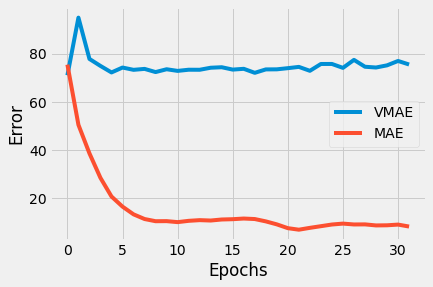

In [63]:
df = pd.DataFrame.from_records(result.history)
df['epoch'] = [i for i in range(df.shape[0])]

plt.plot(df['epoch'], df['val_mean_absolute_error'], label="VMAE")
plt.plot(df['epoch'], df['mean_absolute_error'], label="MAE")
# plt.xticks(df['epoch'])
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [64]:
result.model.save('keras_model.h5')

In [86]:
result.model.predict(X_test)[16]

array([[173.60474]], dtype=float32)